Презентация       https://disk.yandex.ru/i/wJxffcmapmeDfw

Дашборд https://public.tableau.com/views/E-commerce-_16842620072440/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

#      E-commerce — Выявление профилей потребления


## ВВодная часть:

### УСЛОВИЕ: 
Интернет-магазин товаров для дома «Пока все ещё тут» в срочном порядке ищет аналитиков. Вы поможете нашему магазину стать лучше, а клиентам — обустроить дом своей мечты. Наши ближайшие задачи — выявление профилей покупателей, а также их сегментация и анализ.

### Задача:

Сегментировать покупателей по профилю потребления

- Проведите исследовательский анализ данных
- Сегментируйте покупателей на основе истории их покупок
Не бойтесь выдвигать собственные варианты сегментации покупателей. Задумайтесь о том как сегментация может помочь в разработке более персонализированных предложений для покупателей?
Попробуйте сформировать сегменты на основе того, что покупают пользователи. Для этого вы можете проанализировать их покупки и сегментировать товары на основе принадлежности к той или иной товарной категории.
- Сформулируйте и проверьте статистические гипотезы
- По итогам исследования подготовьте презентацию
- По итогам исследования подготовьте Дашборд по набору представленных показателей

### ДАННЫЕ:
Датасеты описывают транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».
Данны два датасета:
  + "ecommerce_dataset.csv"
  + "ecom_dataset_upd.csv"

### ПРЕДМЕТ ИСЛЕДОВАНИЯ: 
Паттерны потребительского поведения сегментов покупателей

### МЕТОДЫ ИССЛЕДОВАНИЯ:
+ Средсва языка PYTHON и его библиотек для анализа и визуализации данных
+ PowerPoint для создания презентации
+ Сервис Tableua  для построения дашборда

## Подготовка среды иследования. 
Загрузка необходимых библиотек и настройки по умолчанию

In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16, 9)})

import pylab
from tqdm.notebook import tqdm
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
import re
import warnings
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [3]:
import nltk

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stopw = nltk.corpus.stopwords.words('russian')
from nltk.probability import FreqDist

!pip install wordcloud
from wordcloud import WordCloud
import string
from itertools import chain

In [4]:
nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Входные данные.
+ Загрузка данных. 
+ Сравнение источников и выбор наиболее репрезентативного
+ Изучение качества входных данных
  + Формат данных
  + Названия столбцов
  + Период исследования
  + Выявление аномалий и пропусков 
  + Итоговая оценка качества данных

### Загрузка данных

Данны два источника данных:  "ecommerce_dataset.csv" и "ecom_dataset_upd.csv". Необходимо использовать все возможные данные 

In [5]:
# чтение файлов с данными и сохранение в df1
try:
    df1 = pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')
except:
    df1 = pd.read_csv('/datasets/ecommerce_dataset.csv')


In [6]:
# чтение файлов с данными и сохранение в df2

google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
df2 = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )


### Сравнение источников и выбор наиболее репрезентативного

In [7]:
# Проверка на равенство
df1.equals(df2)

False

Источники данных отличаются

In [8]:
# Выявляем отличия в источниках 
diff = pd.merge(df1, df2, how='outer', indicator='Exist')

In [9]:
# Оставляем только отличающиеся строки
diff= diff.loc[diff['Exist'] != 'both']
# diff

In [10]:

diff['Exist'].unique()

['right_only']
Categories (1, object): ['right_only']

### Итог проверки источников
+ Источник  "ecom_dataset_upd.csv" (df2) полностью включает в себя данные "ecommerce_dataset.csv"(df1) и содержит дополнительные записи
+ Для более точного анализа, лучше использовать больший датафрейм 

### Изучение качества входных данных

In [11]:
df = df2
df.sample(3)

,date,customer_id,order_id,product,quantity,price
54,2018100217,49b9c587-c19e-4481-bace-967aeac357fa,14481,Пеларгония зональная диам. 12 см сиреневый пол...,1,150.00
5086,2019061109,53d88064-72bd-4d84-8f23-fa6add308a24,71670,Циперус Зумула d-12 см h-25 см,3,112.00
2344,2019031508,71811ebe-8769-4f45-8b34-c61b518ce9e8,70746,Сушилка для белья Colombo Star 18 3679,1,1049.00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [13]:
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [14]:
# Проверка на наличие явных дубликатов 
print('Обнаружено явных дубликатов:', df.duplicated().sum())

Обнаружено явных дубликатов: 0


In [15]:
# Параметры исходных данных

total_customer = len(df['customer_id'].unique())
print('Уникальных покупателей:', total_customer)

total_order = len(df['order_id'].unique())
print('Уникальных заказов:', total_order)

print('Всего товаров:', len(df['product'].unique()))

total_sum = round((df['price'] * df['quantity']).sum(), 2)
print('Общая выручка по датасету: ', total_sum)

Уникальных покупателей: 2451
Уникальных заказов: 3521
Всего товаров: 2343
Общая выручка по датасету:  5357944.42


### Вывод о качестве полученных данных
+ Выбран источник "ecom_dataset_upd.csv", так как в нем представлены все данные
+ Названия колонок в целом отражают содержание и соответствуют стандартному формату написания (Изменения не требуются)
+ Тип даты не соотвествует формату  (Требуются изменения)
+ Остальные типы данных соответствуют содержанию (Изменения не требуются)
+ Пропуски отсутствуют
+ Явных дублей нет

## Предобработка данных
 + Приведение в нужный формат
 + Добавление столбцов с необходимыми расчетными данными
 + Поиск и удаление неявных дубликатов
 + Поиск и удаление выбросов

### Приведение  формата ячеек

In [16]:
#  Приведение даты к формату datetime.
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

Итог: Типы данных в датасете исправлены

### Добавление столбцов

In [17]:
# Добавление столбцов времени
df['dt'] = pd.to_datetime(df['date'].dt.date)
df['time'] = df['date'].dt.time
df['month'] = df['date'].dt.to_period('m')

df['dayofweek'] = df['date'].dt.dayofweek

# Добавление столбца стоимость позиции в заказе
df['revenue'] = df['quantity'] * df['price']

In [18]:
df

,date,customer_id,order_id,product,quantity,price,dt,time,month,dayofweek,revenue
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00,2018-10-01,00:00:00,2018-10,0,142.00
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00,2018-10-01,00:00:00,2018-10,0,194.00
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00,2018-10-01,00:00:00,2018-10,0,112.00
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00,2018-10-01,00:00:00,2018-10,0,179.00
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00,2018-10-01,00:00:00,2018-10,0,112.00
...,...,...,...,...,...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.00,2020-01-30,21:00:00,2020-01,3,76.00
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.00,2020-01-30,22:00:00,2020-01,3,869.00
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.00,2020-01-31,02:00:00,2020-01,4,354.00
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.00,2020-01-31,12:00:00,2020-01,4,128.00


### Поиск и удаление неявных дубликатов

Проверка на корректность заполнения и  однозначности данных.

Для этого необходимо проверить
  + наличие у одного заказа  только одного покупателя 
  + соотношения номера заказа и его даты
  

#### Заказы с одним номером и несколькими покупателями

In [19]:
err_i = df.groupby('order_id')['customer_id'].nunique().sort_values(ascending=False).reset_index()
err_id = err_i[err_i['customer_id'] > 1]
# err_id

In [20]:
# % в общем кол-во заказов
w = err_id['order_id'].count() / total_order
# % в общей сумме
v = df[df['order_id'].isin(err_id['order_id'])]
v = sum(v['price']*v['quantity'])  / total_sum

print(f'Доля выявленных заказов в в общей сумме {v:.2%} и в общем кол-ве заказов {w:.2%}%')

Доля выявленных заказов в в общей сумме 1.75% и в общем кол-ве заказов 0.82%%


Доля таких заказов незначительна, поэтому их можно удалить

In [21]:
# Удаление
df.drop(df[  df['order_id'].isin(err_id['order_id'])   ].index, inplace=True)

In [22]:
df.sample()

,date,customer_id,order_id,product,quantity,price,dt,time,month,dayofweek,revenue
2568,2019-03-31 08:00:00,24cc9ae0-b574-4816-b3f3-01a396842931,14604,Пеларгония зональная махровая лососевая,1,150.00,2019-03-31,08:00:00,2019-03,6,150.00


#### Дубликаты без учета столбцов с  временем.

In [23]:
df[['customer_id', 'order_id', 'product', 'quantity', 'price']].duplicated().sum()

1841

Удаление повторов, оставив только первые по времени строки

In [24]:
df = df.sort_values('date') \
.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'], keep='first')

Проверка у одного заказа нескольких дат

In [25]:
t = df.groupby('order_id')
df[df.index.isin(t.filter(lambda x: x['date'].nunique() > 1).index)]['order_id'].nunique()

23

Эти заказы имеют по несколько дат. Величина также незначительна, поэтому удаляем

In [26]:
# Удаление
df.drop(df[df.index.isin(t.filter(lambda x: x['date'].nunique() > 1).index)].index, axis=0, inplace=True)

In [27]:
print('Количество клиентов после удаления дубликатов:',
      df['customer_id'].nunique(),' - оставшаяся доля от исходных данных:',
      round((df['customer_id'].nunique()/total_customer),2))
print('Количество заказов после удаления дубликатов:',
      df['order_id'].nunique(),'- оставшаяся доля от исходных данных:',
      round((df['order_id'].nunique() / total_order),2))


Количество клиентов после удаления дубликатов: 2394  - оставшаяся доля от исходных данных: 0.98
Количество заказов после удаления дубликатов: 3469 - оставшаяся доля от исходных данных: 0.99


In [28]:
# После удаление дублей можно посчитать стоимость заказа
total = df.groupby('order_id', as_index=False).agg({'revenue':'sum'})
total.rename(columns={'revenue': 'order_total'}, inplace = True )
df = df.merge(total)


In [29]:
# Доход на одного клиента - rpv (Revenue Per User)
rpv = df.groupby('customer_id', as_index=False).agg({'revenue':'sum', 'order_id':'nunique' })
rpv.rename(columns={'revenue': 'rpv','order_id':'q_order' }, inplace = True )
df = df.merge(rpv)

#### Итог:
+ на этапе предобработки мы привели столбец с датой к формату datetime
+ создали отдельные столбцы времени
+ расчитали стоимость позиции в заказе
+ расчитали стоимость заказа
+ расчитали доход на одного клиента
+ расчитали количество заказов на одного клиента
+ в результате удаления дубликатов потеряна незначительная часть данных, менее 2% от исходного датасета


### Поиск и удаление аномалий в данных

Аномалиями будем считать те значения параметров, которые сильно отличаются от остальных.
Часть из них необходимо удалить для защиты результатов исследования от искажений.

Выявление аномальных 
+ потребительских паттернов
+ количества заказов
+ стоимости покупки
+ цены


In [30]:
def boxplots(data, xx, lim = None, *argx):
    plt.figure(figsize=(16, 4))
    ax = sns.boxplot(x= xx,   data=data)
    ax.set_xlim(0, lim)
#     plt.title('')
#     plt.xlabel('')
    plt.show()
# Статистика параметра
    mins = stat.loc['min',xx]
    maxs = stat.loc['max',xx]
    media = stat.loc['50%',xx]
    print(f' Минимальное значение {mins}\n Максимальное значение {maxs}\n Медиана {media} ')

# Находим 1% уникальных значений по методом Z-оценки
    z = np.abs(st.zscore(df[xx]))
    data_clean = df[(z>3)]
    a = data_clean.shape   
    print(" Количество в 1% аномальных значений", a[0])
    

In [31]:
stat = df.describe()
stat

,order_id,quantity,price,dayofweek,revenue,order_total,rpv,q_order
count,5450.00,5450.00,5450.00,5450.00,5450.00,5450.00,5450.00,5450.00
mean,56184.19,2.59,533.60,2.71,836.83,1551.11,6651.43,5.05
std,32487.47,16.61,978.74,1.97,9284.66,9443.34,27336.27,20.11
min,12624.00,1.00,9.00,0.00,9.00,9.00,15.00,1.00
25%,14810.00,1.00,90.00,1.00,120.00,374.00,606.00,1.00
50%,69200.50,1.00,150.00,3.00,194.00,877.00,1218.00,1.00
75%,71970.75,1.00,524.00,4.00,734.00,1759.00,2450.00,2.00
max,112789.00,1000.00,14917.00,6.00,675000.00,675000.00,675000.00,126.00


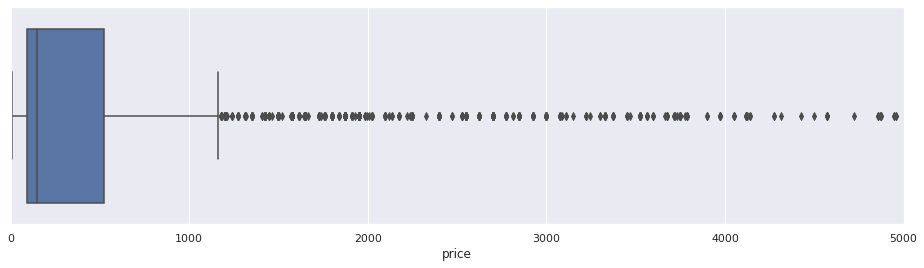

 Минимальное значение 9.0
 Максимальное значение 14917.0
 Медиана 150.0 
 Количество в 1% аномальных значений 137


In [32]:
# Аномальные цены
boxplots(df,'price', 5000)

Выбросы по цене удалять нет смысла

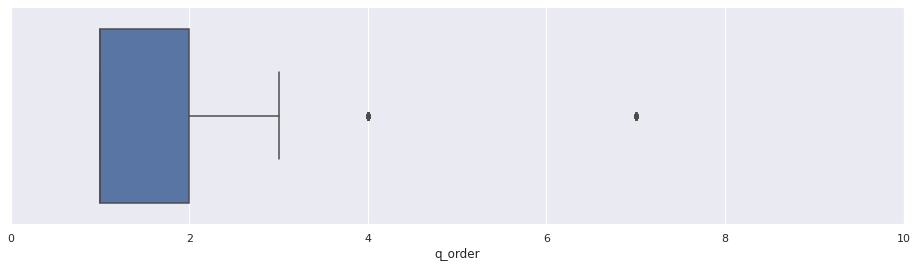

 Минимальное значение 1.0
 Максимальное значение 126.0
 Медиана 1.0 
 Количество в 1% аномальных значений 143


In [33]:
# количество покупок у клиента
boxplots(df,'q_order',10)

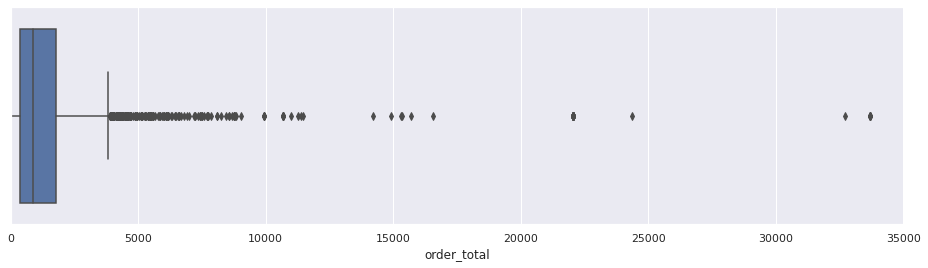

 Минимальное значение 9.0
 Максимальное значение 675000.0
 Медиана 877.0 
 Количество в 1% аномальных значений 10


In [34]:
# стоимости заказа
boxplots(df,'order_total', 35000)

In [35]:
# Информация по аномальным заказам
df.sort_values('order_total', ascending=False).head(10)

,date,customer_id,order_id,product,quantity,price,dt,time,month,dayofweek,revenue,order_total,rpv,q_order
4253,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.00,2019-06-18,15:00:00,2019-06,1,675000.00,675000.00,675000.00,1
4180,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.00,2019-06-11,07:00:00,2019-06,1,49432.00,49432.00,49432.00,1
1461,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-0...,27,1755.00,2019-01-15,13:00:00,2019-01,1,47385.00,47385.00,53232.00,2
1071,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Нож кухонный универсальный с пластмассовой руч...,24,119.00,2018-11-29,17:00:00,2018-11,3,2856.00,33680.00,33680.00,1
1070,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Рыбочистка с деревянной ручкой с ножом 1518024,2,67.00,2018-11-29,17:00:00,2018-11,3,134.00,33680.00,33680.00,1
1073,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Нож кухонный для мяса с пластмассовой ручкой 3...,6,127.00,2018-11-29,17:00:00,2018-11,3,762.00,33680.00,33680.00,1
1074,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.00,2018-11-29,17:00:00,2018-11,3,29248.00,33680.00,33680.00,1
1075,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Кухонные ножницы WEBBER из нержавеющей стали с...,2,127.00,2018-11-29,17:00:00,2018-11,3,254.00,33680.00,33680.00,1
1072,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Нож кухонный для овощей с деревянной ручкой 31...,3,142.00,2018-11-29,17:00:00,2018-11,3,426.00,33680.00,33680.00,1
1317,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,Тележка багажная DELTA ТБР-22 синий грузоподъе...,57,574.00,2018-12-21,16:00:00,2018-12,4,32718.00,32718.00,32718.00,1


Заказ 71743 очень уникальный:
+ стоимость заказа более чем в 10 раз превышает все остальные заказы
+ это был единственный заказ у данного покупателя

Этот заказ необходимо удалить, чтобы не искажать показатели датасета

In [36]:
# Удаление записи
df = df.drop(index=4253)

В данных значительное количество выбросов, но удалять их ненужно, чтобы не потерять ценную аналитическую информацию. Можно для расчета показателя, испытывающего сильное влияние выброса, создать специально отдельный фрейм.

Удалили только 1 заказ - явно ошибочный 

### Вывод:
    - Изучены и удалены дубли
    - Изучены и скоректированы аномалии
    - Исправлены типы данных
    - Добавлены столбцы трансформированых данных, определенные дизайном исследования

Данные подготовлены для исследования

## Анализ и расчет показателей по всей базе

### Общий обзор

In [37]:
# Исследуемый период
firts_date = df['date'].min()
last_date = df['date'].max()
print('Данные от %s до %s, период исследования %s.' % (firts_date, last_date, last_date - firts_date))

Данные от 2018-10-01 00:00:00 до 2020-01-31 15:00:00, период исследования 487 days 15:00:00.


In [38]:
print('Количество покупателей за этот период:', df['customer_id'].nunique())

Количество покупателей за этот период: 2393


In [39]:
print('Количество заказов за этот период:', df['order_id'].nunique())

Количество заказов за этот период: 3468


In [40]:
print('В среднем заказов приходится на покупателя:', round(df['order_id']
                                                           .nunique() / df['customer_id'].nunique(), 2))

В среднем заказов приходится на покупателя: 1.45


На этом этапе видно, что менее половины покупателей возвращаются в магазин за повторными заказами

In [41]:
df.describe()

,order_id,quantity,price,dayofweek,revenue,order_total,rpv,q_order
count,5449.00,5449.00,5449.00,5449.00,5449.00,5449.00,5449.00,5449.00
mean,56181.34,2.41,533.58,2.71,713.10,1427.51,6528.77,5.05
std,32489.77,9.66,978.83,1.97,1667.66,2435.18,25795.39,20.12
min,12624.00,1.00,9.00,0.00,9.00,9.00,15.00,1.00
25%,14810.00,1.00,90.00,1.00,120.00,374.00,606.00,1.00
50%,69200.00,1.00,150.00,3.00,194.00,877.00,1218.00,1.00
75%,71972.00,1.00,524.00,4.00,734.00,1759.00,2450.00,2.00
max,112789.00,334.00,14917.00,6.00,49432.00,49432.00,159508.00,126.00


Большой разброс значений по отдельным параметрам

### Анализ продаж по времени

In [42]:
df_dt = df.groupby('dt').agg({'order_id': 'nunique', 'revenue':'sum' })

df_month = df.groupby('month', as_index=False).agg({'order_id': 'nunique'})

df_dayofweek= df.groupby('dayofweek', as_index=False).agg({'order_id': 'nunique'})

df_time = df.groupby('time', as_index=False).agg({'order_id': 'nunique'})

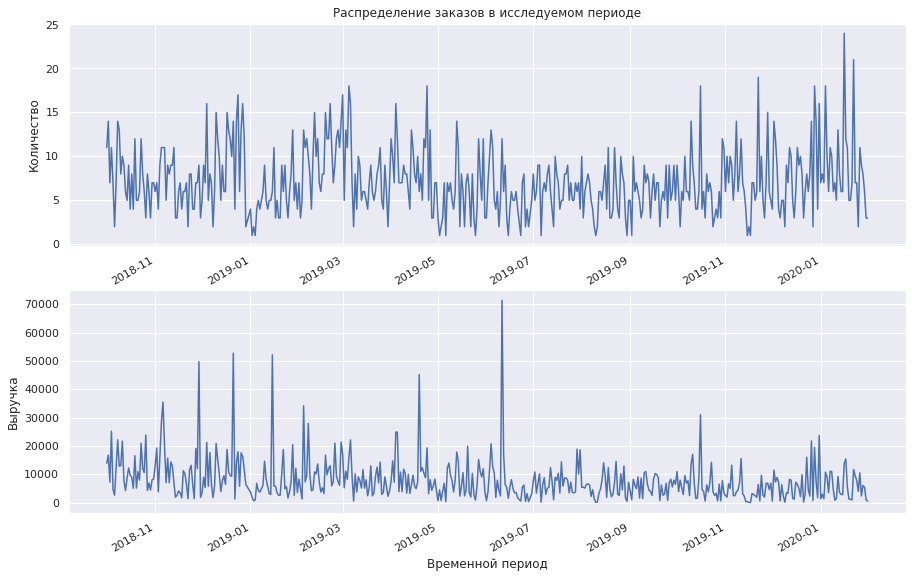

In [43]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,15))
df_dt.plot(y='order_id', figsize=(15, 10), ax=ax1)
df_dt.plot(y='revenue', figsize=(15, 10), ax=ax2)

ax1.set(title='Распределение заказов в исследуемом периоде',  ylabel='Количество')
ax2.set(xlabel='Временной период', ylabel='Выручка')

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

Возможно, наличие высоких пиков в выручке связано с оптовыми закупками

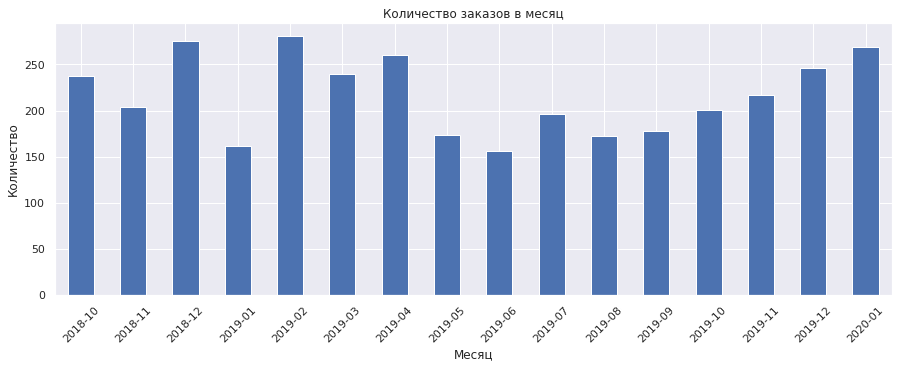

In [44]:

df_month.plot(kind='bar', x='month', figsize=(15, 5))
plt.title('Количество заказов в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.legend().set_visible(False);

+ Более высокие продажи с февралаяпо апрель  объясняется ассортиментом магазина. Видимо основные продажи приходятся на рассаду для огорода. А в конце года праздниками
+ Особое внимание привлекает особенно низкое количество продаж в январе 2019. Вероятнее всего это были какие-то технические неисправности.

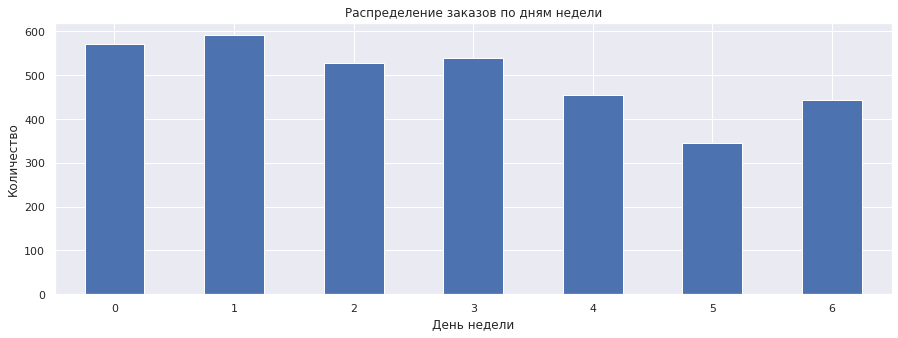

In [45]:
df_dayofweek.plot(kind='bar', x='dayofweek', figsize=(15, 5))
plt.title('Распределение заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество')
plt.legend().set_visible(False)
plt.xticks(rotation=0);

Более низкий уровень активности в конце недели говорит о преобладании корпоративных клиентов

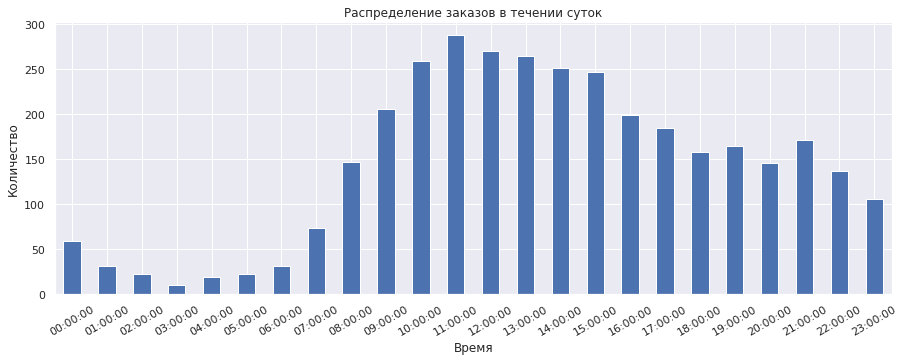

In [46]:
df_time.plot(kind='bar', x='time', figsize=(15, 5))
plt.title('Распределение заказов в течении суток')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.legend().set_visible(False)
plt.xticks(rotation=30);

Основная активность покупателей просходит в дневное время, а с 24:00 до 7-8 затишье. Что косвено говорит о концетрации на локальном рынке, примерно в одной группе часовых поясов.

### Анализ ассортимента

In [47]:
abc = df.groupby('product', as_index=False).agg({'quantity': 'sum', 'revenue':'sum'}) \
        .sort_values('revenue', ascending=False)

In [48]:
a=abc.sort_values('revenue', ascending=False).head(15)
a

,product,quantity,revenue
1183,Простынь вафельная 200х180 см WELLNESS RW180-0...,30,53232.00
1601,Сумка-тележка 2-х колесная Gimi Argo синяя,47,50405.00
189,Вешалки мягкие для деликатных вещей 3 шт шоколад,335,49596.00
1879,Тележка багажная DELTA ТБР-22 синий грузоподъе...,59,33992.00
827,Муляж ЯБЛОКО 9 см красное,618,32702.00
866,Набор ножей Attribute CHEF 5 предметов AKF522,64,29248.00
1627,Сумка-тележка хозяйственная Andersen Scala Sho...,5,28045.00
1684,Сушилка Meliconi Stendy Junior,5,27970.00
833,Мусорный контейнер Hailo BigBin Swing 45 0845-...,5,27560.00
1930,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",5,24370.00


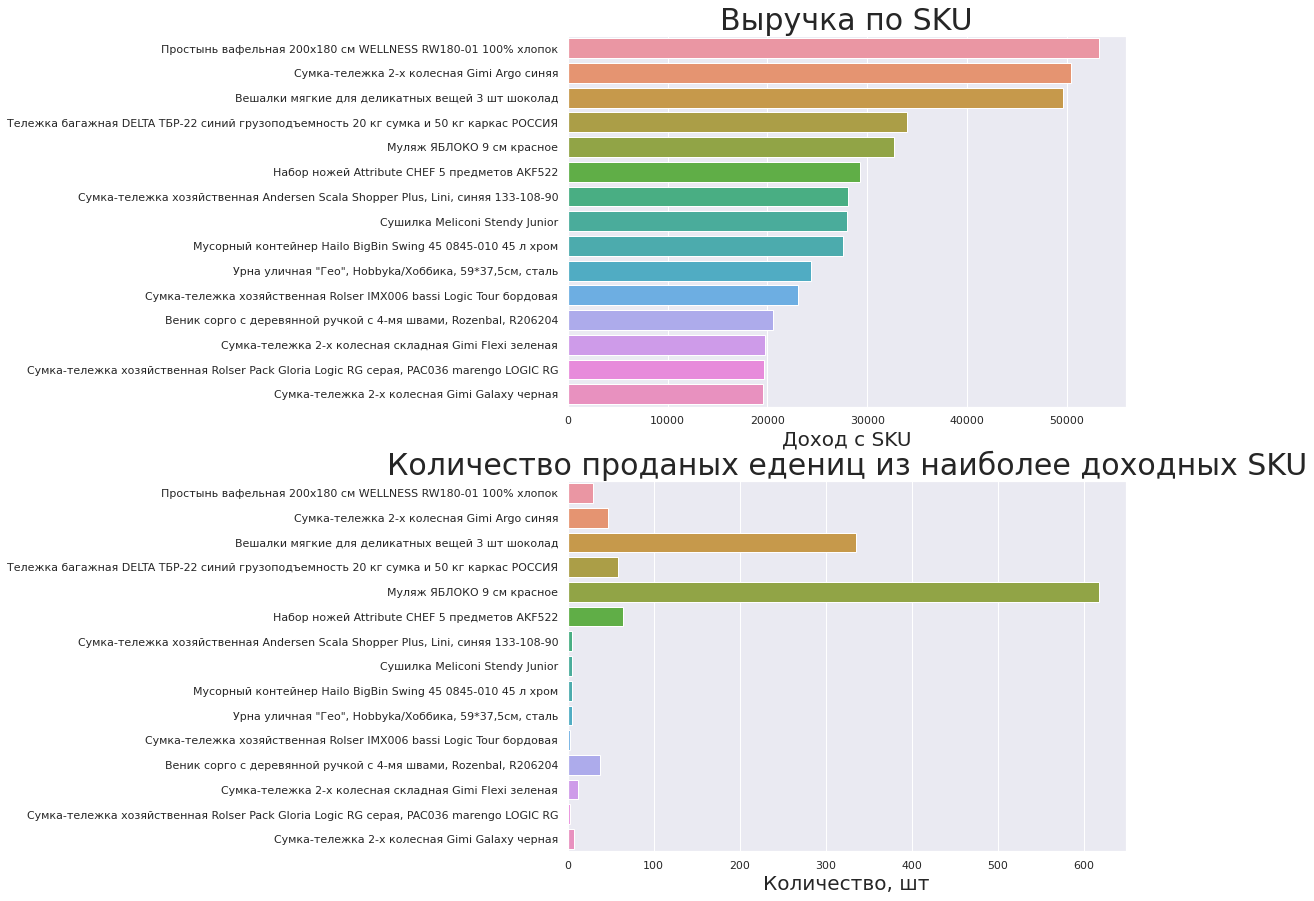

In [49]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,15))
sns.barplot(data=a, x='revenue' , y='product', ax=ax1,  )
sns.barplot(data=a, x='quantity' , y='product', ax=ax2,  )

ax1.set_title('Выручка по SKU',  fontsize = 30)
ax1.set_xlabel('Доход с SKU', fontsize = 20)

ax2.set_title('Количество проданых едениц из наиболее доходных SKU',  fontsize = 30)
ax2.set_xlabel('Количество, шт', fontsize = 20)
ax1.set_ylabel('')
ax2.set_ylabel('')
plt.show()

+ Вешалки хит продаж как по количеству, так и по доходу. Что говорит об устойчивом спросе на них.
+ Остальные позиции крайне нестабильны, возможно это лишь случайные продажи.

### Вывод
+ Относительно небольшое количество покупок, при большом разбросе значений парамтров покупательской ативности затрудняют принятие обоснованных выводов.
+ При сравнении колиства продаж по дням и месяцам, видно множество одиночных пиков в конкретный день при общем стабильном тренде. В диаграмме по месяцам это проявляется в виде сезоности. В пользу этого предположения говорит и сравнение по годам. Так в январе 2019 необычно низкие показатели, так как небыло дневных пиков. Но возможно были тех.неиспрвности 
+ Необходимо получить данные о проведении акций и сравнить с данными о продажах.
+ Распределение по дням недели говорит о наличии В2В покупателей
+ Распределение по часам наиболее ярко показывает разницу  дневной и вечерней активности против почти полного отсутствия ее ночью.
+ Анализ товарного ассортимента выявил трех явных лидеров по выручке: Простынь, сумка-тележка и вешалка.

## Группировка товаров по категориям

### Подготовка названий к сортировке

Проведение поэтапной очистки и лемматизации для выявления ключевых слов в названии товаров
+ Приведение к единому стилю названия товаров
+ Создание списока уникальных названий для дальнейшей обработки
+ Очистка от спец.символов
+ Очиска от стоп слов
+ Лемматизация
+ Определение частотности
+ Определение категорий
+ Составление словарей ключевых слов по категориям
+ Группировка по категориям

In [50]:
# Приводим к нижнему регистру
df['product'] = df['product'].str.lower()

In [51]:
df['product'] 

0         комнатное растение в горшке алое вера, d12, h30
1       комнатное растение в горшке кофе арабика, d12,...
2                             радермахера d-12 см h-20 см
3                        хризолидокарпус лутесценс d-9 см
4                          циперус зумула d-12 см h-25 см
                              ...                        
5445    кружка luminarc дисней микки колорс 250 мл l21...
5446    коврик придверный php srl 40х68 см format mezz...
5447    базилик овощной тонус в кассете 4 штуки средне...
5448     гладильная доска ника lora fashion hlf 123х46 см
5449      крючок проволочный 120 мм оцинкованный, 1110212
Name: product, Length: 5449, dtype: object

In [52]:
# Создаем список уникальных необработанных названий
name_cargo = df['product'].unique().tolist()

#  Всего названий
len(name_cargo)

2320

In [53]:
name_cargo

['комнатное растение в горшке алое вера, d12, h30',
 'комнатное растение в горшке кофе арабика, d12, h25',
 'радермахера d-12 см h-20 см',
 'хризолидокарпус лутесценс d-9 см',
 'циперус зумула d-12 см h-25 см',
 'шеффлера лузеана d-9 см',
 'юкка нитчатая d-12 см h-25-35 см',
 'таз пластмассовый 21,0 л круглый "водолей" с614, 1404056',
 'рассада дыни сорт казачка, горшок 9*9см',
 'настенная сушилка для белья gimi brio super 100',
 'чехол для гладильной доски colombo persia beige 130х50 см из хлопка 5379',
 'чехол для гладильной доски festival 137x60 см из хлопка 4738',
 'набор прищепок большие пластиковые rozenbal пиноккио 10 шт r102312',
 'сушилка для белья attribute прима 11 м синяя напольная adp410',
 'тележка багажная delta тбр-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас россия',
 'готовая скатерть ажурная dia rose круглая д.152 белая, 5173, towa co., ltd',
 'сушилка для белья потолочная zalger lift basic 1520 200 см, 10 м',
 'таз пластмассовый 18,0 л квадр

### Удаление спец. символов и цифр

In [54]:
# Список для удаления
spec_chars = string.punctuation + '\n\xa0«»\t—…' + string.digits
spec_chars

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\xa0«»\t—…0123456789'

In [55]:
# Функция обработки для отдельной строки (одного названия товара)
def chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

In [56]:
# Применение функции к каждому элементу в списке названий
a=[]
for i in name_cargo:
    a.append(chars_from_text(i, spec_chars))

In [57]:
a

['комнатное растение в горшке алое вера d h',
 'комнатное растение в горшке кофе арабика d h',
 'радермахера d см h см',
 'хризолидокарпус лутесценс d см',
 'циперус зумула d см h см',
 'шеффлера лузеана d см',
 'юкка нитчатая d см h см',
 'таз пластмассовый  л круглый водолей с ',
 'рассада дыни сорт казачка горшок см',
 'настенная сушилка для белья gimi brio super ',
 'чехол для гладильной доски colombo persia beige х см из хлопка ',
 'чехол для гладильной доски festival x см из хлопка ',
 'набор прищепок большие пластиковые rozenbal пиноккио  шт r',
 'сушилка для белья attribute прима  м синяя напольная adp',
 'тележка багажная delta тбр коричневый с оранжевым грузоподъемность  кг сумка и  кг каркас россия',
 'готовая скатерть ажурная dia rose круглая д белая  towa co ltd',
 'сушилка для белья потолочная zalger lift basic   см  м',
 'таз пластмассовый  л квадратный тп пластхозторг ',
 'стяжка оконная с болтом ст цинк ',
 'сумкатележка х колесная gimi tris floral синяя',
 'сумкатележ

### Удаление стоп-слов

In [58]:
# Список стоп-слов
stopw = nltk.corpus.stopwords.words('russian')
stopw.extend(["см", 'л', 'для', 'd','м','h', 'шт','х','сорт', 'объем','диам' ])
# stopwords

In [59]:
# Функция обработки для отдельной строки (одного названия товара)
def stop_from_text(text):
    text_tokens = word_tokenize(text) 
    return " ".join([word for word in text_tokens if not word in stopw])

In [60]:
# Применение функции к каждому элементу в списке названий
b=[]
for i in a:
    b.append(stop_from_text(i))
    

In [61]:
b

['комнатное растение горшке алое вера',
 'комнатное растение горшке кофе арабика',
 'радермахера',
 'хризолидокарпус лутесценс',
 'циперус зумула',
 'шеффлера лузеана',
 'юкка нитчатая',
 'таз пластмассовый круглый водолей',
 'рассада дыни казачка горшок',
 'настенная сушилка белья gimi brio super',
 'чехол гладильной доски colombo persia beige хлопка',
 'чехол гладильной доски festival x хлопка',
 'набор прищепок большие пластиковые rozenbal пиноккио r',
 'сушилка белья attribute прима синяя напольная adp',
 'тележка багажная delta тбр коричневый оранжевым грузоподъемность кг сумка кг каркас россия',
 'готовая скатерть ажурная dia rose круглая д белая towa co ltd',
 'сушилка белья потолочная zalger lift basic',
 'таз пластмассовый квадратный тп пластхозторг',
 'стяжка оконная болтом ст цинк',
 'сумкатележка колесная gimi tris floral синяя',
 'сумкатележка хозяйственная andersen scala shopper elba черная',
 'герань домашняя пеларгония зональная цветущая красная махровая',
 'герань дома

### Лемматизация

In [62]:
from pymystem3 import Mystem
m = Mystem()
def lemmatize_sentence(text):
    lemmas = m.lemmatize(text)
    return "".join(lemmas).strip()

In [63]:
d=[]
for i in b:
    d.append(lemmatize_sentence(i))

In [64]:
d

['комнатный растение горшок алый вера',
 'комнатный растение горшок кофе арабика',
 'радермахер',
 'хризолидокарпус лутесценс',
 'циперус зумул',
 'шеффлер лузеан',
 'юкка нитчатый',
 'таз пластмассовый круглый водолей',
 'рассада дыня казачка горшок',
 'настенный сушилка белье gimi brio super',
 'чехол гладильный доска colombo persia beige хлопок',
 'чехол гладильный доска festival x хлопок',
 'набор прищепок большой пластиковый rozenbal пиноккио r',
 'сушилка белье attribute прима синий напольный adp',
 'тележка багажный delta тбр коричневый оранжевый грузоподъемность кг сумка кг каркас россия',
 'готовый скатерть ажурный dia rose круглый д белый towa co ltd',
 'сушилка белье потолочный zalger lift basic',
 'таз пластмассовый квадратный тп пластхозторг',
 'стяжка оконный болт ст цинк',
 'сумкатележка колесный gimi tris floral синий',
 'сумкатележка хозяйственный andersen scala shopper elba черный',
 'герань домашний пеларгония зональный цвести красный махровый',
 'герань домашний пел

Подготовка данных о названии товаров проведена в достаточном объёме 

### Выявление ключивых слов

In [65]:
# Облако слов
for_wordcloud = list(chain(*d))
for_wordcloud = ' '.join(d)
# for_wordcloud

In [66]:
# wc = WordCloud(background_color="white", max_words=2000)
# plt.figure(figsize = (12, 10), facecolor = None) 
# wc.generate(for_wordcloud)
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")
# plt.show()

Облако не работает

###  Выбор способа сортировки

In [67]:
first_word = []
two_word = []
for i in d:
    sub = word_tokenize(i)
    first_word.append(sub[0])
    if len(sub)>1:
        two_word.append(f'{sub[0]} {sub[1]}')
    else:
        two_word.append(sub[0])

In [68]:
first_word

['комнатный',
 'комнатный',
 'радермахер',
 'хризолидокарпус',
 'циперус',
 'шеффлер',
 'юкка',
 'таз',
 'рассада',
 'настенный',
 'чехол',
 'чехол',
 'набор',
 'сушилка',
 'тележка',
 'готовый',
 'сушилка',
 'таз',
 'стяжка',
 'сумкатележка',
 'сумкатележка',
 'герань',
 'герань',
 'герань',
 'герань',
 'декоративный',
 'искусственный',
 'чехол',
 'светильник',
 'таз',
 'сумкатележка',
 'салфетка',
 'щетка',
 'сушилка',
 'гладильный',
 'чехол',
 'рыбочистка',
 'сидение',
 'сушилка',
 'сумкатележка',
 'бальзамин',
 'герань',
 'герань',
 'фиалка',
 'чайник',
 'салфетка',
 'чехол',
 'сушилка',
 'корзина',
 'пробка',
 'таз',
 'сумкатележка',
 'гладильный',
 'гладильный',
 'сушилка',
 'подрукавник',
 'сушилка',
 'гладильный',
 'кисточка',
 'кисточка',
 'коврик',
 'скребок',
 'средство',
 'штора',
 'сушилка',
 'чехол',
 'бальзамин',
 'сушилка',
 'штора',
 'сумкатележка',
 'миска',
 'одеяло',
 'герань',
 'сушилка',
 'лестницастремянка',
 'штора',
 'сумкатележка',
 'ерш',
 'коврик',
 'сушилка

In [69]:
two_word

['комнатный растение',
 'комнатный растение',
 'радермахер',
 'хризолидокарпус лутесценс',
 'циперус зумул',
 'шеффлер лузеан',
 'юкка нитчатый',
 'таз пластмассовый',
 'рассада дыня',
 'настенный сушилка',
 'чехол гладильный',
 'чехол гладильный',
 'набор прищепок',
 'сушилка белье',
 'тележка багажный',
 'готовый скатерть',
 'сушилка белье',
 'таз пластмассовый',
 'стяжка оконный',
 'сумкатележка колесный',
 'сумкатележка хозяйственный',
 'герань домашний',
 'герань домашний',
 'герань домашний',
 'герань домашний',
 'декоративный композиция',
 'искусственный цветок',
 'чехол гладильный',
 'светильник настольный',
 'таз пластмассовый',
 'сумкатележка колесный',
 'салфетка protec',
 'щетка палубный',
 'сушилка белье',
 'гладильный доска',
 'чехол гладильный',
 'рыбочистка металлический',
 'сидение унитаз',
 'сушилка белье',
 'сумкатележка хозяйственный',
 'бальзамин новогвинейский',
 'герань домашний',
 'герань домашний',
 'фиалка микс',
 'чайник электрический',
 'салфетка protec',
 '

In [70]:

first_word_cnt = FreqDist(first_word)
first_word_cnt

FreqDist({'рассада': 173, 'сушилка': 112, 'сумкатележка': 84, 'томат': 78, 'коврик': 72, 'гладильный': 70, 'муляж': 68, 'пеларгония': 60, 'чехол': 52, 'штора': 52, ...})

In [71]:
first_word_cnt.most_common(50)

[('рассада', 173),
 ('сушилка', 112),
 ('сумкатележка', 84),
 ('томат', 78),
 ('коврик', 72),
 ('гладильный', 70),
 ('муляж', 68),
 ('пеларгония', 60),
 ('чехол', 52),
 ('штора', 52),
 ('роза', 47),
 ('петуния', 42),
 ('искусственный', 40),
 ('набор', 37),
 ('таз', 35),
 ('вешалка', 33),
 ('тарелка', 33),
 ('скатерть', 28),
 ('корзина', 23),
 ('стремянка', 23),
 ('герань', 21),
 ('тележка', 19),
 ('чайник', 18),
 ('салатник', 18),
 ('цветок', 18),
 ('однолетний', 16),
 ('подвесной', 15),
 ('банка', 14),
 ('цикламен', 14),
 ('флокс', 14),
 ('щетка', 13),
 ('кружка', 13),
 ('контейнер', 12),
 ('примула', 12),
 ('нож', 11),
 ('капуста', 11),
 ('калибрахоа', 11),
 ('полка', 10),
 ('фуксия', 10),
 ('фиалка', 9),
 ('лестницастремянка', 9),
 ('ерш', 9),
 ('пуансеттия', 9),
 ('швабра', 9),
 ('ведро', 9),
 ('вербена', 9),
 ('комнатный', 8),
 ('салфетка', 8),
 ('бакоп', 8),
 ('карниз', 8)]

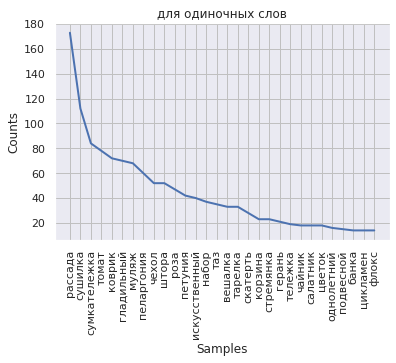

In [72]:
# Служебный график для определения частот методом "локтя" для одиночных слов
first_word_cnt.plot(30,cumulative=False, title =('для одиночных слов'))
plt.show()

In [73]:
two_word_cnt = FreqDist(two_word)
two_word_cnt

FreqDist({'сушилка белье': 109, 'томат помидор': 73, 'гладильный доска': 68, 'рассада зелень': 68, 'сумкатележка хозяйственный': 61, 'штора ванный': 40, 'пеларгония зональный': 39, 'искусственный цветок': 36, 'таз пластмассовый': 34, 'роза садовый': 32, ...})

In [74]:
two_word_cnt.most_common(50)

[('сушилка белье', 109),
 ('томат помидор', 73),
 ('гладильный доска', 68),
 ('рассада зелень', 68),
 ('сумкатележка хозяйственный', 61),
 ('штора ванный', 40),
 ('пеларгония зональный', 39),
 ('искусственный цветок', 36),
 ('таз пластмассовый', 34),
 ('роза садовый', 32),
 ('чехол гладильный', 31),
 ('коврик придверный', 31),
 ('рассада капуста', 30),
 ('герань домашний', 21),
 ('рассада томат', 20),
 ('цветок искусственный', 18),
 ('корзина белье', 16),
 ('однолетний растение', 16),
 ('сумкатележка колесный', 15),
 ('подвесной кашпо', 15),
 ('рассада огурец', 15),
 ('чехол одежда', 13),
 ('тарелка десертный', 13),
 ('тележка багажный', 12),
 ('тарелка обеденный', 12),
 ('флокс метельчатый', 12),
 ('салатник luminarc', 10),
 ('полка qwerty', 10),
 ('примула комнатный', 9),
 ('комнатный растение', 8),
 ('чайник электрический', 8),
 ('пеларгония розебудный', 8),
 ('набор вешалка', 8),
 ('бакоп ампельный', 8),
 ('тарелка суповой', 8),
 ('рассада тыква', 8),
 ('рассада кабачок', 8),
 ('ко

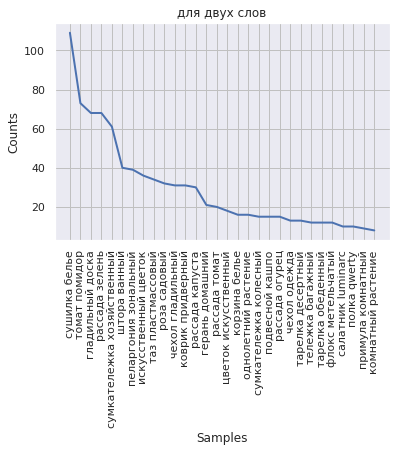

In [75]:
# Служебный график для определения частот методом "локтя" для двух слов
two_word_cnt.plot(30,cumulative=False, title=('для двух слов'))
plt.show()

В результате получился список наиболее часто встречаемых слов. На его основе можно определить категории товаров:
+ растение  
+ хозтовары 
+ интерьер      
+ сумки         
+ товары для кухни      

### Составление словарей

Из списка слов составляем словарь категорий

In [76]:
cat_dict = {'растение': ['комнатное',
  'радермахера',  'хризолидокарпус',  'циперус',  'мединилла',  'шеффлера',  'юкка',  'многолетнее',  'рассада',  'герань',
  'пеларгония',  'суккулент',  'эхеверия',  'эвкалипт',  'цветок',  'адиантум',  'кампанула',  'калатея',  'нолина',  'хлорофитум',
  'цикламен',  'глоксиния',  'азалия',  'гортензия',  'хризантема',  'мирт',  'цветущее',  'кориандр',  'иссоп',  'сантолина',
  'аспарагус',  'афеляндра',  'антуриум',  'молодило',  'фиалка',  'гербера',  'душица',  'мелисса',  'роза',  'бегония',  'розмарин',
  'альбука',  'бальзамин',  'крассула',  'артемизия',  'лаванда',  'мята',  'каланхое',  'примула',  'дендробиум',  'калоцефалус',
  'каллуна',  'капсикум',  'мимоза',  'соланум',  'бархатцы',  'космея',  'морковь',  'настурция',  'огурец',  'петуния',  'алиссум',
  'гвоздика',  'годеция',  'календула',  'капуста',  'кореопсис',  'лапчатка',  'львиный',  'флокс',  'цинерария',  'эшшольция',
  'диффенбахия',  'фаленопсис',  'подсолнечник',  'пуансетия',  'гиностемма',  'ель',  'кипарисовик',  'аптения',  'новогоднее',
  'пуансеттия',  'скиммия',  'фиттония',  'тимьян',  'алоэ',  'спатифиллум',  'фикус',  'кодонанта',  'цикламен,',  'гимнокалициум',
  'кофе',  'эхинокактус',  'фал',  'крокусы',  'гипсофила',  'калибрахоа',  'эпипремнум',  'аквилегия',  'базилик',  'горох',
  'земляника',  'незабудка',  'седум',  'томат',  'укроп',  'нефролепис',  'калла',  'декабрист',  'тюльпан',  'гиацинт',
  'вербена',  'однолетнее',  'чабер',  'бакопа',  'ранункулус',  'газания',  'овсянница',  'георгина',  'смолевка',  'цинния',
  'лавр',  'вербейник',  'виола',  'колокольчик',  'котовник',  'эхинацея',  'ясколка',  'лилейник',  'папоротник',  'платикодон',
  'энотера',  'фуксия',  'цитрофортунелла',  'пеперомия',  'дыня',  'циния',  'синнингия',  'гардения',  'томата',  'лобелия',
  'табак',  'девичий',  'мускари',  'пиретрум',  'агератум',  'колеус',  'тагетис',  'цинерания',  'муррайя',  'портулак',  'астра',
  'аргирантерум',  'левкой',  'вероника',  'целозия',  'арбуз',  'баклажан',  'клубника',  'патиссон',  'маттиола',  'сальвия',
  'лук',  'джункус',  'драцена',  'фатсия',  'хоста',  'гайлардия',  'монарда',  'нивянник',  'рудбекия',  'барвинок',  'осина',
  'сциндапсус',  'пряные',  'бузульник',  'камнеломка',  'солидаго',  'физостегия',  'бадан',  'лен',  'лантана',  'лаватера',  'анемона',
  'буддлея',  'валериана',  'змееголовник',  'любисток',  'петрушка',  'сельдерей',  'шалфей',  'вигна',  'кабачок',  'тыква',
  'хамедорея',  'зверобой',  'импатиенс',  'клен',  'замиокулькас',  'амариллис',  'салат',  'пахира',  'литопс'], 
   
  'хозтовары':
                 ['настенная',  'антинакипин',  'таз',  'чехол',  'вешалка',  'сушилка',  'крючок',  'корзина',  'доска',
                  'щетка-сметка',  'ерш',  'набор',  'подкладка',  'ёрш',  'мусорный',  'перчатки',  'стремянка',  'гладильная',
                  'лестница-стремянка', 'стяжка',  'комплект',  'плечики',  'крепеж',  'пружина',  'петля',  'стиральный',
                  'чистящий',  'щетка',  'стремянки',  'щетка-утюжок',  'жидкое',  'пена',  'подрукавник',  'сверло-фреза,',
                  'зубная',  'веник',  'швабра',  'насадка',  'ножеточка',  'вешалка-плечики',  'настольная',  'холодная',
                  'шнур',  'урна',  'мыло',  'сметка',  'измерительный',  'линейка,',  'средство',  'бензин',  'паста',
                  'петля-стрела',  'вешалка-стойка',  'держатель',  'пробка',  'вешалки',  'губка',  'антижир',  
                  'универсальное',  'ролик',  'сменный',  'термометр',  'шило',  'кухонные',  'ароматизированное',  'бальзам',
                  'рассекатель',  'ополаскиватель',  'сетка',  'вешалка-сушилка',  'ручка-скоба',  'мыльница',
                  'многофункциональный', 'стремянка-табурет',  'кольца',  'вантуз',  'кондиционер',  'защитная',
                  'гипоаллергенный',  'вешалка-перекладина',  'лестница',  'совок',  'насадка-отжим',  'штанга',  'увлажняющая',
                  'штангенциркуль',  'мыло-скраб',  'рукав',  'бак',  'концентрат',  'окномойка',  'сменная',  'насадка-моп',
                  'подвесное',  'автоматическая',  'тряпкодержатель',  'бельевые',  'сверло',  'фиксатор-шар',  'отжим',
                  'шпагат',  'ванна',  'прищепки',  'покрытие',  'веревка',  'мешок',  'отбеливатель',  'ручка',
                  'пьезозажигалка',  'решетка',  'запасная',  'щётка',  'уголок',  'вакуумный',  'тряпка',  'основание',
                  'стяжки', 'ведро', 'ящик',  'шпингалет'],
                 
 'для кухни': ['мини-сковорода',  'сковорода',  'стеклянная',  'тарелка',  'вилка',  'ложка',  'нож',  'котел',  'дозатор',
            'кувшин',  'толкушка',  'банка',  'противень',  'вкладыши',  'tepмокружка',  'контейнер',  'масленка',  'корыто',
            'салатник',  'чайный',  'рыбочистка',  'терка',  'кружка',  'лопатка',  'салфетница',  'стакан',  'столовая',
            'чайная',  'овощечистка',  'лоток',  'ковш',  'кисточка',  'скребок',  'картофелемялка',  'жестяная',  'миска',
            'пресс',  'термостакан',  'защитный',  'термокружка',  'термос',  'фарфоровая',  'столовый',  'блюдце',  'бульонница',
            'разделочная',  'емкость',  'модульная',  'просеиватель',  'кастрюля',  'хлебница',  'форма',  'орехоколка',
            'скалка',  'венчик',  'сито',  'тортница',  'блюдо',  'сотейник',  'бидон',  'ваза',  'отделитель',  'шприц',
            'крышка',  'сахарница',  'универсальный',  'половник',  'мерный', 'чайник',  'миксер',  'светильник', 'утюг',  
            'овощеварка',  'измельчитель',  'фен',  'мантоварка',  'весы', 'электроштопор',  'мантоварка-пароварка',  
            'пылесос',  'соковарка',  'соковыжималка',  'кипятильник'],
                 
 'сумки': ['сумка-тележка',  'сумка',  'тележка',  'кофр',   'короб',  'коробка',  'складная',  'корзинка'],
                 
 'интерьер': ['муляж',  'коврик',  'плед',  'скатерть',  'ковер',  'готовая',  'искусственный',  'простыня',  
              'штора',  'декоративная',  'подушка',  'полотенце',  'салфетка',  'ковёр',  'карниз',  'подголовник', 
              'наматрасник',  'наматрицник-чехол',  'сиденье',  'сервировочная',  'халат',  'комод',  'покрывало',  
              'подставка',  'одеяло',  'фоторамка',  'этажерка',  'простынь',  'полки',  'ключница',  'махровое',
              'искусственная',  'нетканые',  'кухонное',  'подарочный',  'махровый',  'полка',  'урна-пепельница',
              'ткань',  'наматрацник',  'наволочка',  'обувница-3',  'пододеяльник',  'стеллаж',  'складной',  
              'завертка',  'двуспальное'],
                 
}

### Группировка товаров по категориям

In [77]:
# Функция для группировки
def category(name):
    for key, value in cat_dict.items():
        for word in value:
            if name.find(word) > -1:
                return key
    return 'Прочее'

In [78]:
#  Группировка
df['category'] = df['product'].apply(category)

In [79]:
#к Таблица распределения товаров по товарным категориям
cargo = df.groupby('category').agg({'product':'nunique'})  \
.sort_values('product', ascending=False) 

cargo

,product
category,
растение,1250
хозтовары,485
интерьер,254
для кухни,219
сумки,112


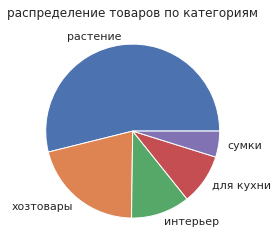

In [80]:
# График распределение товаров по категориям
cargo['product'].plot(kind='pie', ylabel = '', title ='распределение товаров по категориям' )
plt.show()

In [81]:
# Таблица продаж в товарных категориях
df['category'].value_counts(ascending = False)

растение     3410
хозтовары     861
интерьер      471
сумки         367
для кухни     340
Name: category, dtype: int64

In [82]:
df.head(3)

,date,customer_id,order_id,product,quantity,price,dt,time,month,dayofweek,revenue,order_total,rpv,q_order,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.00,2018-10-01,00:00:00,2018-10,0,142.00,1037.00,1037.00,1,растение
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.00,2018-10-01,00:00:00,2018-10,0,194.00,1037.00,1037.00,1,растение
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.00,2018-10-01,00:00:00,2018-10,0,112.00,1037.00,1037.00,1,растение


### Вывод:
+ Разделение товаров по категориям произведена
+ Нераспределённых товаров нет
+ Категория "Растения" составляют более половины ассортимента

## Сегментация покупателей методом RFM-анализа

Так как магазин продает товары с коротким срок использования, то для сегментации покупателей можно применить RFM-анализ.

In [83]:
# Таблица стоимости заказов
orders = df.groupby(['order_id', 'date', 'customer_id']).agg({'revenue': 'sum'}).reset_index()
orders.head()

,order_id,date,customer_id,revenue
0,12624,2019-06-02 20:00:00,d17861fa-db5f-4de4-93fd-dc5e60d24d3e,375.00
1,13547,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,684.00
2,14480,2018-10-02 11:00:00,f08d9018-438e-4e96-b519-f74c0302a433,359.00
3,14481,2018-10-02 17:00:00,49b9c587-c19e-4481-bace-967aeac357fa,600.00
4,14482,2018-10-07 12:00:00,43993fd2-20c9-44f7-8634-cf0aee26df4f,376.00


Обычно при сегментации RFM используют период один год

In [84]:
# Момент анализа
NOW = orders['date'].max() + timedelta(days=1)
NOW

Timestamp('2020-02-01 15:00:00')

In [85]:
period = 365

In [86]:
# Количество дней с даты заказа до момента анализа
orders['past_day'] =(NOW - orders['date']).dt.days

In [87]:
aggr = {
    'past_day': lambda x: x.min(),                                              #  Recency
    'date': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]),   #  Frequency
}

rfm = orders.groupby('customer_id').agg(aggr).reset_index()
rfm.rename(columns={'past_day': 'recency', 'date': 'frequency'}, inplace=True)
rfm.head()

,customer_id,recency,frequency
0,000d6849-084e-4d9f-ac03-37174eaf60c4,108,1
1,001cee7f-0b29-4716-b202-0042213ab038,350,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1


In [88]:
# Продажи за последний год
rfm['monetary'] = rfm['customer_id'].apply(lambda x: orders[(orders['customer_id'] == x) & \
                                    (orders['date'] >= NOW - timedelta(days=period))]\
                                                           ['revenue'].sum())
rfm.head()

,customer_id,recency,frequency,monetary
0,000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.00
1,001cee7f-0b29-4716-b202-0042213ab038,350,1,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,0,0.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.00


Использование квинтилей является более гибким, поскольку диапазоны будут адаптироваться к данным и будут работать в разных отраслях или при любых изменениях в ожидаемом поведении клиентов.

In [89]:
# Использован метод квинтилей
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 58.400000000000034,
  0.4: 137.80000000000007,
  0.6: 266.0,
  0.8: 372.0},
 'frequency': {0.2: 0.0, 0.4: 1.0, 0.6: 1.0, 0.8: 2.0},
 'monetary': {0.2: 0.0, 0.4: 268.0, 0.6: 688.2, 0.8: 1622.2000000000023}}

In [90]:
{'frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0},
  'monetary': {0.2: 215.89800000000002,
  0.4: 440.432,
  0.6: 876.3679999999999,
  0.8: 1909.6580000000006},
  'recency': {0.2: 11.0, 0.4: 32.0, 0.6: 71.0, 0.8: 178.80000000000018}}

{'frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0},
 'monetary': {0.2: 215.89800000000002,
  0.4: 440.432,
  0.6: 876.3679999999999,
  0.8: 1909.6580000000006},
 'recency': {0.2: 11.0, 0.4: 32.0, 0.6: 71.0, 0.8: 178.80000000000018}}

In [91]:
# Присвоения рангов от 1 до 5
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [92]:
# Формирование рейтинга покупателя
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['M'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head(10)

,customer_id,recency,frequency,monetary,R,F,M,RFM Score
0,000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.00,4,2,3,423
1,001cee7f-0b29-4716-b202-0042213ab038,350,1,442.00,2,2,3,223
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.00,4,2,4,424
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,0,0.00,2,1,1,211
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.00,4,2,5,425
5,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,370,0,0.00,2,1,1,211
6,005ba170-45e8-42de-93f7-192481ae2659,87,1,6658.00,4,2,5,425
7,00bd74b1-2792-47db-a2f1-680a09ac5026,468,0,0.00,1,1,1,111
8,00c0f92a-121a-4883-a78d-2c7b5fe187de,51,2,321.00,5,4,3,543
9,00c95d20-923e-4b45-88fc-53b12931d462,44,1,186.50,5,2,2,522


In [93]:
# Присвоение категории покупателям
segt_map = {
    r'[1-2][1-2]': 'потерянные',
    r'[1-2][3-4]': 'в зоне риска',
    r'[1-2]5': 'в зоне риска',
    r'3[1-2]': 'уходящие',
    r'33': 'нуждающиеся во внимании',
    r'[3-4][4-5]': 'постоянные',
    r'41': 'многообещающие',
    r'51': 'новые клиенты',
    r'[4-5][2-3]': 'потенциально лояльны',
    r'5[4-5]': 'лучшие'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_id,recency,frequency,monetary,R,F,M,RFM Score,Segment
0,000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.00,4,2,3,423,потенциально лояльны
1,001cee7f-0b29-4716-b202-0042213ab038,350,1,442.00,2,2,3,223,потерянные
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.00,4,2,4,424,потенциально лояльны
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,0,0.00,2,1,1,211,потерянные
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.00,4,2,5,425,потенциально лояльны


In [94]:
cid = rfm.groupby('Segment').agg({'customer_id':'nunique'}).sort_values('customer_id')
cid

,customer_id
Segment,
в зоне риска,50
постоянные,101
уходящие,431
потенциально лояльны,441
лучшие,465
потерянные,905


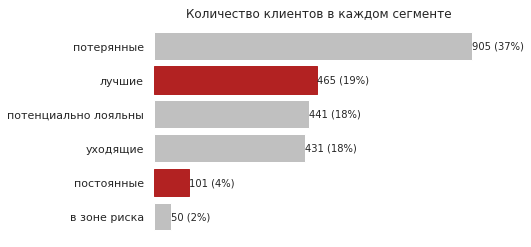

In [95]:
# количество клиентов в каждом сегменте
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['лучшие', 'постоянные']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
plt.title('Количество клиентов в каждом сегменте ')
plt.show()

##  Проверка гипотез о разнице в показателях сегментов

In [96]:
# функция критерия Манна-Уитни
def U_test(cat1, cat2, text):
    pval = st.mannwhitneyu(cat1, cat2)[1]
    alpha = 0.05/15
    
# Вывод результатов проверки 
    
    if pval > alpha:
        print('Не можем отклонить Н0. P-value:','{}'.format(pval))
        print(text,' {0:.3f}'.format(cat1.mean()/cat2.mean()))
    else:
        print('Отклоняем Н0. P-value:','{}'.format(pval))
        print(text,' {0:.3f}'.format(cat1.mean()/cat2.mean()))
    print('='*30)     

In [97]:
# значение text в функции
text_avg = 'Отношение средних чеков:'
text_quit = 'Отношение количества заказов на покупателя:'

In [98]:
# Список сегментов
lst = rfm['Segment'].unique()
lst

array(['потенциально лояльны', 'потерянные', 'лучшие', 'уходящие',
       'постоянные', 'в зоне риска'], dtype=object)

### Проверка гипотезы: различия среднего чека между сегментами 

Мы не можем утверждать, что выборки имеют нормальное распределения, поэтому воспользуемся непараметрическим тестом Манна-Уитни.

Гипотезы для проверки: 
  - H0 - нет различий между средним чеком среди кластеров
  - H1 - есть различия между средним чеком среди кластеров

In [99]:
# Таблица стоимости заказов
df_cost = orders.merge(rfm[['customer_id','Segment']])
df_cost

,order_id,date,customer_id,revenue,past_day,Segment
0,12624,2019-06-02 20:00:00,d17861fa-db5f-4de4-93fd-dc5e60d24d3e,375.00,243,уходящие
1,13547,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,684.00,484,потерянные
2,14480,2018-10-02 11:00:00,f08d9018-438e-4e96-b519-f74c0302a433,359.00,487,потерянные
3,14481,2018-10-02 17:00:00,49b9c587-c19e-4481-bace-967aeac357fa,600.00,486,потерянные
4,14494,2018-10-23 13:00:00,49b9c587-c19e-4481-bace-967aeac357fa,752.00,466,потерянные
...,...,...,...,...,...,...
3463,108602,2019-12-31 14:00:00,fd4af93f-9fbd-449f-91f8-b42b830e265b,569.00,32,потенциально лояльны
3464,108900,2020-01-03 09:00:00,753660bf-a1ea-4447-853d-622e47c1c6ac,97.00,29,потенциально лояльны
3465,111090,2020-01-07 19:00:00,6921ac3e-bfcd-4a05-95d3-12ef81e874cc,899.00,24,потенциально лояльны
3466,111091,2020-01-08 17:00:00,a843e87d-c9b8-475a-96fb-1edcccca5f8e,60.00,23,потенциально лояльны


In [100]:
cost = df_cost.groupby(['Segment','customer_id'], as_index=False).agg({'revenue':'mean'})

In [101]:
cost = cost.rename(columns={'revenue': 'avg_check'})

In [102]:
cost

,Segment,customer_id,avg_check
0,в зоне риска,02adb72a-3067-45e9-a3b5-f93d79d7496a,5361.50
1,в зоне риска,08199320-6a87-4a2c-8565-dfc0c8484184,67.00
2,в зоне риска,11f83991-ae0e-40bb-83ff-497f24103e75,130.50
3,в зоне риска,15056e00-1aaf-483b-b429-4e9f41ee82b6,209.00
4,в зоне риска,1c6bdff3-29ba-4241-8b03-5c1aae217c8e,712.00
...,...,...,...
2388,уходящие,fab25c31-09e3-49a6-aa85-4a46ddb1ce14,2324.00
2389,уходящие,fad81093-6fbd-4b50-b03e-aa4d2d974158,734.00
2390,уходящие,fc9218e5-4f2d-425b-becd-af5a050a3e36,112.00
2391,уходящие,fc9641ba-8f74-45de-a60a-342d2e0dd7af,152.00


In [103]:
# Проверка гипотезы: различия среднего чека между сегментами
q=0
for i in range(len(lst)):
    for j in range(i+1,len(lst)):
        cat1 = cost.loc[(cost['Segment'] == lst[i]),'avg_check']
        cat2 = cost.loc[(cost['Segment'] == lst[j]),'avg_check']
        print(lst[i],' = x = ', lst[j])
        U_test(cat1, cat2, text_avg)
        q+=1
print(q)        

потенциально лояльны  = x =  потерянные
Отклоняем Н0. P-value: 6.223578368693435e-05
Отношение средних чеков:  0.700
потенциально лояльны  = x =  лучшие
Не можем отклонить Н0. P-value: 0.497004450010033
Отношение средних чеков:  1.107
потенциально лояльны  = x =  уходящие
Не можем отклонить Н0. P-value: 0.03436220745296805
Отношение средних чеков:  0.732
потенциально лояльны  = x =  постоянные
Не можем отклонить Н0. P-value: 0.29327800823338235
Отношение средних чеков:  0.944
потенциально лояльны  = x =  в зоне риска
Не можем отклонить Н0. P-value: 0.268765278673447
Отношение средних чеков:  1.020
потерянные  = x =  лучшие
Отклоняем Н0. P-value: 1.3520997475435552e-06
Отношение средних чеков:  1.582
потерянные  = x =  уходящие
Не можем отклонить Н0. P-value: 0.1412744421824507
Отношение средних чеков:  1.046
потерянные  = x =  постоянные
Не можем отклонить Н0. P-value: 0.21606940427011068
Отношение средних чеков:  1.349
потерянные  = x =  в зоне риска
Не можем отклонить Н0. P-value: 0.

#### Результат теста:
Тест показал незначительные отличия (или их осутствие) в среднем чеке. Возможно, это связано с ассортиментом магазина. Неоходимо ровести дополнительные тесты по другим ключивым показателям

### Проверка гипотезы: различия в количестве заказов между сегментами

  - H0 - нет различия в количестве заказов между кластерами
  - H1 - есть различия в количестве заказов между кластерами

In [104]:
# Таблица количества заказов по клиенту
customer = df_cost.groupby(['customer_id','Segment' ]).agg({'order_id': 'nunique'}).reset_index()
customer.sample(3)

,customer_id,Segment,order_id
599,3fb078a8-eccf-4780-b130-3bde6b8c6b10,уходящие,1
1140,7bb6c73d-a9e6-47a1-85f2-6bcdbf81408d,лучшие,2
24,01ca3206-da26-470d-8240-f34e7086c214,потерянные,1


In [105]:
# Проверка гипотезы: различия в количестве заказов между сегментами
for i in range(len(lst)):
    for j in range(i+1,len(lst)):
        cat1 = customer.loc[(customer['Segment'] == lst[i]),'order_id']
        cat2 = customer.loc[(customer['Segment'] == lst[j]),'order_id']
        print(lst[i],' = x = ', lst[j])
        U_test(cat1, cat2, text_quit)

потенциально лояльны  = x =  потерянные
Отклоняем Н0. P-value: 4.9826406801356745e-93
Отношение количества заказов на покупателя:  1.397
потенциально лояльны  = x =  лучшие
Отклоняем Н0. P-value: 4.0309891882257736e-68
Отношение количества заказов на покупателя:  0.752
потенциально лояльны  = x =  уходящие
Отклоняем Н0. P-value: 3.450303289975459e-65
Отношение количества заказов на покупателя:  1.503
потенциально лояльны  = x =  постоянные
Отклоняем Н0. P-value: 9.866553530779397e-25
Отношение количества заказов на покупателя:  0.652
потенциально лояльны  = x =  в зоне риска
Отклоняем Н0. P-value: 5.1922229594540586e-15
Отношение количества заказов на покупателя:  0.317
потерянные  = x =  лучшие
Отклоняем Н0. P-value: 4.669440249480091e-267
Отношение количества заказов на покупателя:  0.538
потерянные  = x =  уходящие
Отклоняем Н0. P-value: 7.831264886900785e-05
Отношение количества заказов на покупателя:  1.076
потерянные  = x =  постоянные
Отклоняем Н0. P-value: 1.5865291495789484e-1

#### Результат теста:
Тест показал ярко выраженные различия в потребительской активности сегментов

### Вывод:
Такое сегментирование обосновано.

## Изучение потребительских предпочтений по сегментам покупателей

### Общий обзор отличий

In [106]:
df = df.merge(rfm[['customer_id','Segment']])

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5449 entries, 0 to 5448
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5449 non-null   datetime64[ns]
 1   customer_id  5449 non-null   object        
 2   order_id     5449 non-null   int64         
 3   product      5449 non-null   object        
 4   quantity     5449 non-null   int64         
 5   price        5449 non-null   float64       
 6   dt           5449 non-null   datetime64[ns]
 7   time         5449 non-null   object        
 8   month        5449 non-null   period[M]     
 9   dayofweek    5449 non-null   int64         
 10  revenue      5449 non-null   float64       
 11  order_total  5449 non-null   float64       
 12  rpv          5449 non-null   float64       
 13  q_order      5449 non-null   int64         
 14  category     5449 non-null   object        
 15  Segment      5449 non-null   object        
dtypes: dat

### Средний чек

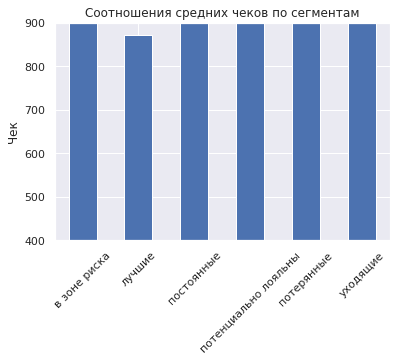

,Segment,avg_check
0,в зоне риска,947.53
1,лучшие,873.04
2,постоянные,1023.70
3,потенциально лояльны,966.25
4,потерянные,1381.22
5,уходящие,1320.77


In [108]:
avg =cost.groupby('Segment').agg({'avg_check':'mean'})
avg.plot(kind='bar', ylim=(400, 900))
plt.title('Соотношения средних чеков по сегментам')
plt.xlabel('')
plt.ylabel('Чек')
plt.legend().set_visible(False)
plt.xticks(rotation=45)     
plt.show()
avg.reset_index()

Средние чеки не отличаются, за исключением сегмента "в зоне риска"

### Динамика активности сегментов по выручке

In [109]:
df.sample()

,date,customer_id,order_id,product,quantity,price,dt,time,month,dayofweek,revenue,order_total,rpv,q_order,category,Segment
566,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,коврик влаговпитывающий ребристый 60х90 см ста...,1,412.00,2018-10-26,13:00:00,2018-10,4,412.00,22056.00,22056.00,1,растение,потерянные


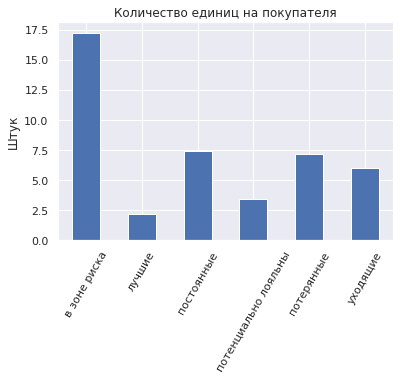

,avg_quant
Segment,
в зоне риска,17.24
лучшие,2.11
постоянные,7.37
потенциально лояльны,3.38
потерянные,7.15
уходящие,5.98


In [110]:
avg_quant =df.groupby('Segment').agg({'quantity':'sum', 'customer_id':'nunique'})
avg_quant['avg_quant'] = avg_quant['quantity'] / avg_quant['customer_id']
avg_quant.plot(kind='bar', y='avg_quant') 
plt.title('Количество единиц на покупателя')
plt.xlabel('')
plt.ylabel('Штук')
plt.legend().set_visible(False)
plt.xticks(rotation=60)     
plt.show()
avg_quant[['avg_quant']]

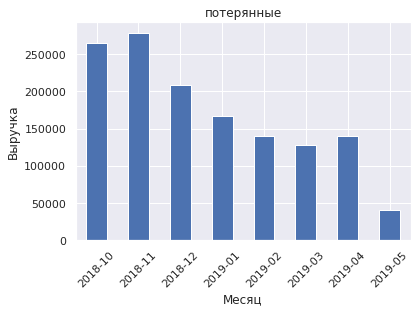

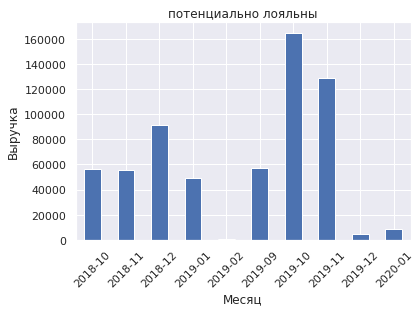

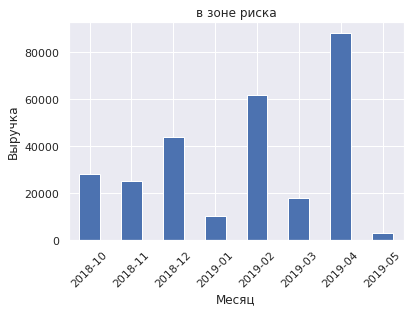

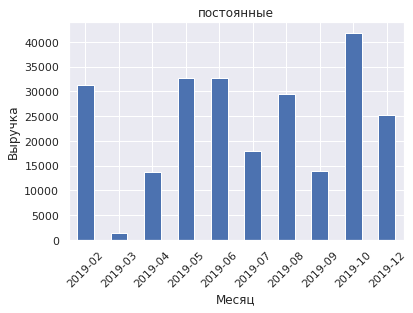

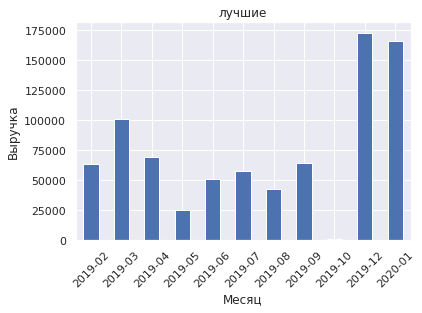

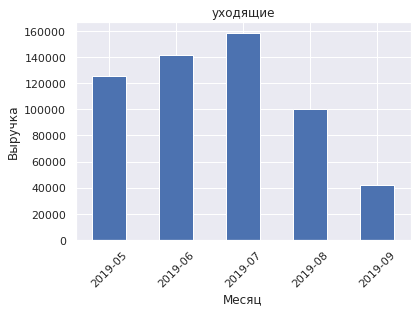

In [111]:
# Выручка
for i in df['Segment'].unique() :
    a = df[df['Segment'] == i]
    b = a.groupby('month', as_index=False).agg({'revenue':'sum'})
    xx = b['month']
    yy = b['revenue']
    b.plot( kind='bar', y="revenue", x="month",sharey=True)
    plt.title(i)
    plt.xlabel('Месяц')
    plt.ylabel('Выручка')
    plt.legend().set_visible(False)
    plt.xticks(rotation=45)     
    plt.show()

### Вывод 1:
Удивительное распределение выручки по сегментам. Если в целом по базе активность примерно равномерна, то по сегментам очень сильно колеблется. Даже у лояльных сегментов есть месяца совсем без продаж.
Думаю, это из-за небольшого количества покупателей в сегментах при малой частоте покупок. При большем количестве событий спрос будет выравниваться.

### Товарные предпочтения

In [112]:
# Выручка по категории товара
segm = df.groupby(['Segment', 'category']).agg({'order_id' : 'count', 'revenue': 'sum' }).reset_index()

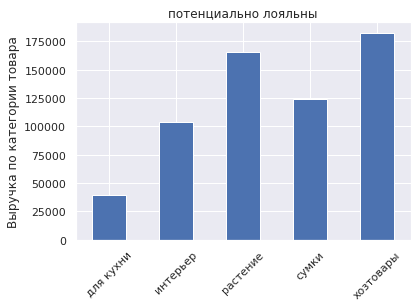

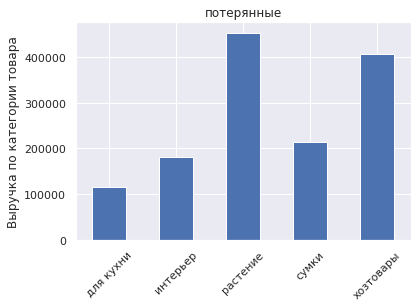

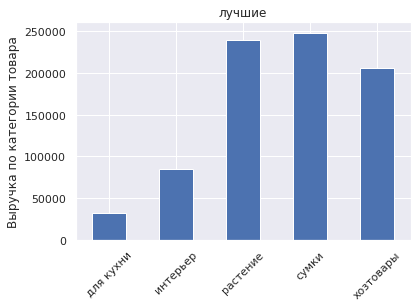

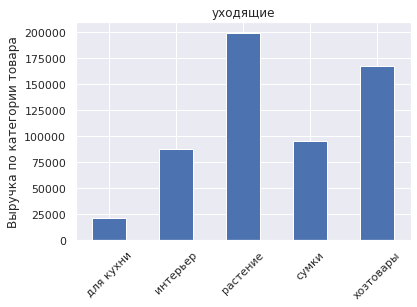

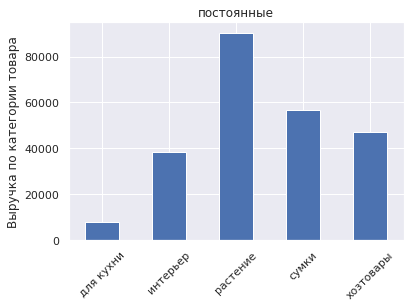

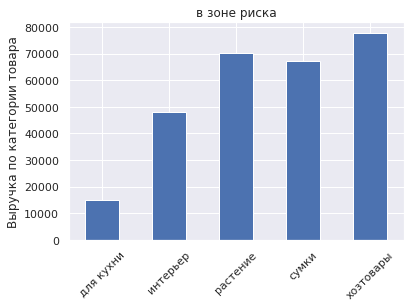

In [113]:
for i in lst:
    d = segm[segm['Segment'] == i]
    d.plot( kind='bar', x='category', y='revenue')    
    plt.title(i)
    plt.xlabel('')
    plt.ylabel('Выручка по категории товара')
    plt.legend().set_visible(False)
    plt.xticks(rotation=45);   

### Вывод 2:

После изучения товарных предпочтений можно уточнить рекомендации для отдела маркетинга 

+ В целом растения интересуют все сегменты покупателей. Но это основная товарная категория магазина
+ Наиболее значим выявленный интерес к сумкам и хозтоварам (близкие категории, возможно объедение) у наиболее важных для маркетингового воздействия сегментов, таких как: "лучшие", "уходящие", "потенциально лояльны"
+ А вот постоянные (имеющие стабильный средний спрос) сосредоточены на растениях. Поэтому можно ввести более дорогие позиции растений и доп. аксессуары, чтобы увеличить средний чек


## Вывод и рекомендации

### Статистика показателей:
+ Покупателей – 2393
+ Заказов - 3468 
+ В среднем на одного покупателя приходится 1,45 заказа
+ Данные представлены за период 2018-10-01 по 2020-01-31
+ Период исследования 487 дней.
+ Выявлено шесть сегментов покупателей на основе потребительского поведения
(в зоне риска	50, постоянные	101, уходящие	431, потенциально лояльны	441, лучшие	465, потерянные	905)
+ Распеделение неравномерно. Большая часть "потеряных"
+ Средний чек у всех сегментов одинаков, кроме сегмента "в зоне риска"
+ Распределение количества купленных товаров в штуках: в зоне риска	17.24, лучшие	2.11, постоянные	7.37, потенциально лояльны	3.38, потерянные	7.15, уходящие	5.98
+ Выявлено пять категорий товаров.
+ Распределение по категориям товаров, неравномерно. В основном это категоря "растения"
(растение	1250, хозтовары	485, интерьер	254, для кухни	219, сумки	112)
+ Наиболее доходные позиции: простыни, сумки-тележки и вешалки



### Рекомедации по сегментам

#### Лучшие
+ Описание сегмента: Купил недавно, покупает часто и тратит больше всех
+ Количество: 465
+ Средний чек: 838.77
+ Количество товаров: 2.11
+ Товарные предпочтения: сумки, хозтовары, растения
+ С такими необходимо работать персонально: предлагать что-то ценное, например, золотую карту или приглашение на отраслевое мероприятие.

#### Постоянные	
Описание сегмента: Покупают на регулярной основе. Реагирует на рекламные акции. Рентабильность средняя.
+ Количество: 101
+ Средний чек: 849.59
+ Количество товаров: 7.37
+ Товарные предпочтения: растения
+ На них хорошо действуют стандартные рекламные кампании, разрабатывать какие-то индивидуальные варианты не стоит.

#### Потенциально лояльны
Описание сегмента: Недавние клиенты со средней частотой.
+ Количество: 441
+ Средний чек: 810.26
+ Количество товаров: 3.38
+ Товарные предпочтения: хозтовары, растения
+ Наладьте как можно больше коммуникаций: поздравьте с покупкой, пригласите на сайт или в социальные сети почитать интересные и полезные статьи в блоге и т.п. Постарайтесь сделать из них лояльных потребителей, которые всегда будут обращаться в вашу компанию.

#### Уходящие	
Описание сегмента: Покупал не очень давно. Частота ниже среднего
+ Количество: 431
+ Средний чек: 863.05
+ Количество товаров: 5.98
+ Товарные предпочтения: хозтовары, растения
+ Попробуйте наладить контакт, предложить скидки или специальные предложения

#### В зоне риска
Описание сегмента: Покупал давно. Частота и денежные показатели выше среднего.
+ Количество: 50
+ Средний чек: 577.64
+ Количество товаров: 17.24
+ Товарные предпочтения: хозтовары, растения, сумки
+ Выясните, почему они перестали совершать покупки? Спровоцируйте на новую сделку: индивидуальные условия, скидки, акции и т.п

#### Потерянные
Описание сегмента: Новизна и частота ниже среднего.
+ Количество: 905
+ Средний чек: 834.03
+ Количество товаров: 7.15
+ Товарные предпочтения: хозтовары, растения
+ Попробуйте наладить контакт, предложить скидки или специальные предложения. Но если нет отклика, то откажитесь от дальнейшей работы. Сосредоточьтесь на более ценных сегментах.

### Вывод

Главная проблема компании "Пока все ещё тут" в том, что она плохо справляется с удержанием клиентов. Большинство клиентов предпочитает совершать мелкие покупки один-два раза и больше не возвращаться. Однако, в такой негативной тенденции оттока клиентов есть довольно большая группа лояльных постоянных клиентов.

Отчёт позволит маркетологам сэкономить бюджет, проработать стратегию по возврату спящих и уходящих клиентов, подтолкнуть клиента к переходу между сегментами или поощрить самых выгодных клиентов, не напрягая никого из них бесполезными и неинтересными предложениями, что в свою очередь если и не повысит лояльность клиента, то как минимум не опустит её.